# RESISC45 Model Training: ResNet-18 & ViT-S/16

This notebook trains both classification architectures (ResNet-18 and ViT-S/16) on the RESISC45 dataset subset (11 classes).

**Methodology:** Identical to EuroSAT training from thesis Chapter 3
- Stratified 70/15/15 split (train/val/test)
- Same hyperparameters, augmentation, and training procedures
- Models saved for subsequent compression evaluation

**Dataset:** RESISC45 subset with 11 classes (15,400 images total)
- 256×256 RGB images (higher resolution than EuroSAT's 64×64)
- Classes: beach, circular_farmland, dense_residential, forest, freeway, industrial_area, lake, meadow, medium_residential, rectangular_farmland, river

## Setup & Imports

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install timm  # For Vision Transformer

In [3]:
import os
import json
import random
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm.auto import tqdm
import timm

import matplotlib.pyplot as plt
import seaborn as sns

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


## Configuration

In [4]:
# Paths
DATASET_ROOT = Path("/content/drive/MyDrive/MA_Thesis/UNCOMP/RESISC45_EUROSAT_SUBSET_11")
OUTPUT_ROOT = Path("/content/drive/MyDrive/MA_Thesis/RESISC45_SUBSET_Training")
OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

# Dataset classes (11 classes from your subset)
CLASSES = [
    'beach', 'circular_farmland', 'dense_residential', 'forest', 'freeway',
    'industrial_area', 'lake', 'meadow', 'medium_residential',
    'rectangular_farmland', 'river'
]
NUM_CLASSES = len(CLASSES)

# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


## Dataset Preparation

**Stratified 70/15/15 split** - identical to EuroSAT methodology

In [5]:
def collect_image_paths(root_dir: Path, classes: List[str]) -> Tuple[List[Path], List[int]]:
    """
    Collect all image paths and labels.

    Returns:
        image_paths: List of Path objects
        labels: List of class indices
    """
    image_paths = []
    labels = []

    for class_idx, class_name in enumerate(classes):
        class_dir = root_dir / class_name
        if not class_dir.exists():
            print(f"⚠️  Warning: Class directory not found: {class_dir}")
            continue

        # Collect all .jpg files (filter macOS artifacts)
        class_images = [p for p in class_dir.glob("*.jpg") if not p.name.startswith('._')]

        image_paths.extend(class_images)
        labels.extend([class_idx] * len(class_images))

        print(f"{class_name}: {len(class_images)} images")

    return image_paths, labels

# Collect all images
print("Collecting images...")
all_paths, all_labels = collect_image_paths(DATASET_ROOT, CLASSES)
print(f"\nTotal images: {len(all_paths)}")
print(f"Class distribution: {dict(zip(*np.unique(all_labels, return_counts=True)))}")

beach: 700 images
circular_farmland: 700 images
dense_residential: 700 images
forest: 700 images
freeway: 700 images
industrial_area: 700 images
lake: 700 images
meadow: 700 images
medium_residential: 700 images
rectangular_farmland: 700 images
river: 700 images

Total images: 7700
Class distribution: {np.int64(0): np.int64(700), np.int64(1): np.int64(700), np.int64(2): np.int64(700), np.int64(3): np.int64(700), np.int64(4): np.int64(700), np.int64(5): np.int64(700), np.int64(6): np.int64(700), np.int64(7): np.int64(700), np.int64(8): np.int64(700), np.int64(9): np.int64(700), np.int64(10): np.int64(700)}


In [6]:
def create_stratified_split(image_paths: List[Path], labels: List[int],
                           train_ratio: float = 0.7,
                           val_ratio: float = 0.15,
                           test_ratio: float = 0.15,
                           random_state: int = 42) -> Dict:
    """
    Create stratified train/val/test split.

    Methodology from thesis Section 3.2:
    - 70% training, 15% validation, 15% test
    - Stratified to ensure equal class proportions
    - Random state 42 for reproducibility
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"

    # Convert to arrays
    X = np.array(image_paths)
    y = np.array(labels)

    # First split: train vs (val+test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        train_size=train_ratio,
        stratify=y,
        random_state=random_state
    )

    # Second split: val vs test
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        train_size=val_ratio_adjusted,
        stratify=y_temp,
        random_state=random_state
    )

    return {
        'train': {'paths': X_train.tolist(), 'labels': y_train.tolist()},
        'val': {'paths': X_val.tolist(), 'labels': y_val.tolist()},
        'test': {'paths': X_test.tolist(), 'labels': y_test.tolist()}
    }

# Create split
print("Creating stratified 70/15/15 split...")
split_data = create_stratified_split(all_paths, all_labels, random_state=RANDOM_SEED)

print(f"\nTrain: {len(split_data['train']['paths'])} images")
print(f"Val:   {len(split_data['val']['paths'])} images")
print(f"Test:  {len(split_data['test']['paths'])} images")

# Verify stratification
for split_name in ['train', 'val', 'test']:
    labels = split_data[split_name]['labels']
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{split_name.capitalize()} class distribution:")
    for cls_idx, count in zip(unique, counts):
        print(f"  {CLASSES[cls_idx]}: {count}")

Creating stratified 70/15/15 split...

Train: 5390 images
Val:   1155 images
Test:  1155 images

Train class distribution:
  beach: 490
  circular_farmland: 490
  dense_residential: 490
  forest: 490
  freeway: 490
  industrial_area: 490
  lake: 490
  meadow: 490
  medium_residential: 490
  rectangular_farmland: 490
  river: 490

Val class distribution:
  beach: 105
  circular_farmland: 105
  dense_residential: 105
  forest: 105
  freeway: 105
  industrial_area: 105
  lake: 105
  meadow: 105
  medium_residential: 105
  rectangular_farmland: 105
  river: 105

Test class distribution:
  beach: 105
  circular_farmland: 105
  dense_residential: 105
  forest: 105
  freeway: 105
  industrial_area: 105
  lake: 105
  meadow: 105
  medium_residential: 105
  rectangular_farmland: 105
  river: 105


In [7]:
# Save split indices for reproducibility
split_file = OUTPUT_ROOT / "split_indices.json"

# Convert Path objects to strings for JSON serialization
split_data_serializable = {
    split_name: {
        'paths': [str(p) for p in data['paths']],
        'labels': data['labels']
    }
    for split_name, data in split_data.items()
}

with open(split_file, 'w') as f:
    json.dump(split_data_serializable, f, indent=2)

print(f"✓ Split indices saved to: {split_file}")

✓ Split indices saved to: /content/drive/MyDrive/MA_Thesis/RESISC45_SUBSET_Training/split_indices.json


## Dataset Class

In [8]:
class RESISC45Dataset(Dataset):
    """RESISC45 Dataset for PyTorch"""

    def __init__(self, image_paths: List[str], labels: List[int], transform=None):
        self.image_paths = [Path(p) for p in image_paths]
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

## Data Transforms

**From thesis Section 3.4.1 & 3.4.2:**
- ImageNet normalization (mean: [0.485, 0.456, 0.406], std: [0.229, 0.224, 0.225])
- Training augmentation: RandomHorizontalFlip, RandomVerticalFlip, RandomRotation (±10°), ColorJitter
- Satellite images have no canonical orientation → flip/rotation appropriate

In [9]:
# ImageNet normalization statistics
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def get_transforms(model_type: str, augment: bool = False):
    """
    Get transforms for ResNet or ViT.

    Args:
        model_type: 'resnet' or 'vit'
        augment: If True, apply training augmentation
    """
    if model_type == 'resnet':
        # ResNet: Native RESISC45 resolution (256×256)
        base_transforms = [
            transforms.Resize((256, 256)),  # Ensure consistent size
        ]
    elif model_type == 'vit':
        # ViT: Requires 224×224 (standard ViT input size)
        base_transforms = [
            transforms.Resize((224, 224)),
        ]
    else:
        raise ValueError(f"Unknown model_type: {model_type}")

    if augment:
        # Training augmentation (thesis Section 3.4.1)
        augment_transforms = [
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.ColorJitter(
                brightness=0.2,
                contrast=0.2,
                saturation=0.2,
                hue=0.0  # Don't change hue for satellite imagery
            ),
        ]
    else:
        augment_transforms = []

    # Final transforms
    final_transforms = [
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ]

    return transforms.Compose(base_transforms + augment_transforms + final_transforms)

## Training Functions

In [10]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="Training")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({
            'loss': f"{running_loss/len(pbar):.4f}",
            'acc': f"{100.*correct/total:.2f}%"
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * accuracy_score(all_labels, all_preds)

    return val_loss, val_acc, all_preds, all_labels

## Model 1: ResNet-18

**From thesis Section 3.4.1:**
- ImageNet pretrained weights
- Final FC layer: 512 → 11 (adapted for 11 classes)
- Optimizer: Adam (lr=1e-3, weight_decay=1e-4)
- Max epochs: 20, early stopping (patience=5)
- Batch size: 64
- LR scheduler: ReduceLROnPlateau (factor=0.1, patience=3)

In [17]:
# Hyperparameters for ResNet-18
RESNET_CONFIG = {
    'lr': 1e-3,
    'weight_decay': 1e-4,
    'batch_size': 64,
    'max_epochs': 20,
    'early_stop_patience': 5,
    'lr_patience': 3,
    'lr_factor': 0.1
}

print("ResNet-18 Configuration:")
for k, v in RESNET_CONFIG.items():
    print(f"  {k}: {v}")

ResNet-18 Configuration:
  lr: 0.001
  weight_decay: 0.0001
  batch_size: 64
  max_epochs: 20
  early_stop_patience: 5
  lr_patience: 3
  lr_factor: 0.1


In [18]:
# Create ResNet-18 dataloaders
resnet_train_transform = get_transforms('resnet', augment=True)
resnet_val_transform = get_transforms('resnet', augment=False)

resnet_train_dataset = RESISC45Dataset(
    split_data['train']['paths'],
    split_data['train']['labels'],
    transform=resnet_train_transform
)

resnet_val_dataset = RESISC45Dataset(
    split_data['val']['paths'],
    split_data['val']['labels'],
    transform=resnet_val_transform
)

resnet_train_loader = DataLoader(
    resnet_train_dataset,
    batch_size=RESNET_CONFIG['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

resnet_val_loader = DataLoader(
    resnet_val_dataset,
    batch_size=RESNET_CONFIG['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"ResNet-18 DataLoaders created:")
print(f"  Train batches: {len(resnet_train_loader)}")
print(f"  Val batches: {len(resnet_val_loader)}")

ResNet-18 DataLoaders created:
  Train batches: 85
  Val batches: 19


In [19]:
# Initialize ResNet-18
print("Loading ResNet-18 with ImageNet pretrained weights...")
resnet_model = models.resnet18(pretrained=True)

# Replace final FC layer (512 → 11 classes)
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, NUM_CLASSES)

resnet_model = resnet_model.to(DEVICE)
print(f"✓ ResNet-18 loaded (final FC: {num_features} → {NUM_CLASSES})")

# Loss & Optimizer
resnet_criterion = nn.CrossEntropyLoss()
resnet_optimizer = optim.Adam(
    resnet_model.parameters(),
    lr=RESNET_CONFIG['lr'],
    weight_decay=RESNET_CONFIG['weight_decay']
)
resnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    resnet_optimizer,
    mode='min',
    factor=RESNET_CONFIG['lr_factor'],
    patience=RESNET_CONFIG['lr_patience']
)

print(f"✓ Optimizer: Adam (lr={RESNET_CONFIG['lr']}, wd={RESNET_CONFIG['weight_decay']})")
print(f"✓ Scheduler: ReduceLROnPlateau (patience={RESNET_CONFIG['lr_patience']})")

Loading ResNet-18 with ImageNet pretrained weights...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 155MB/s]

✓ ResNet-18 loaded (final FC: 512 → 11)
✓ Optimizer: Adam (lr=0.001, wd=0.0001)
✓ Scheduler: ReduceLROnPlateau (patience=3)


In [19]:
# Train ResNet-18
print("\n" + "="*60)
print("Training ResNet-18")
print("="*60)

best_val_acc = 0.0
best_epoch = 0
epochs_without_improvement = 0
resnet_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(1, RESNET_CONFIG['max_epochs'] + 1):
    print(f"\nEpoch {epoch}/{RESNET_CONFIG['max_epochs']}")

    # Train
    train_loss, train_acc = train_epoch(
        resnet_model, resnet_train_loader, resnet_criterion, resnet_optimizer, DEVICE
    )

    # Validate
    val_loss, val_acc, _, _ = validate(
        resnet_model, resnet_val_loader, resnet_criterion, DEVICE
    )

    # Update scheduler
    resnet_scheduler.step(val_loss)

    # Save history
    resnet_history['train_loss'].append(train_loss)
    resnet_history['train_acc'].append(train_acc)
    resnet_history['val_loss'].append(val_loss)
    resnet_history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Check for improvement
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        epochs_without_improvement = 0

        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': resnet_model.state_dict(),
            'optimizer_state_dict': resnet_optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss
        }, OUTPUT_ROOT / 'resnet18_best.pth')

        print(f"✓ New best model saved (Val Acc: {val_acc:.2f}%)")
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s)")

    # Early stopping
    if epochs_without_improvement >= RESNET_CONFIG['early_stop_patience']:
        print(f"\nEarly stopping triggered after {epoch} epochs")
        break

print(f"\n{'='*60}")
print(f"ResNet-18 Training Complete")
print(f"Best Val Acc: {best_val_acc:.2f}% (Epoch {best_epoch})")
print(f"{'='*60}")

# Save training history
with open(OUTPUT_ROOT / 'resnet18_history.json', 'w') as f:
    json.dump(resnet_history, f, indent=2)


Training ResNet-18

Epoch 1/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.5657, Train Acc: 81.95%
Val Loss: 0.5517, Val Acc: 83.90%
✓ New best model saved (Val Acc: 83.90%)

Epoch 2/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    ^^
self._shutdown_workers()
AssertionError:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
can o

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    AssertionError: self._shutdown_workers()
can only test a child process
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in:     if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480>

Traceback (most recent call last):
   File "/usr/loca

Train Loss: 0.3389, Train Acc: 88.91%
Val Loss: 0.2464, Val Acc: 91.17%
✓ New best model saved (Val Acc: 91.17%)

Epoch 3/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.2819, Train Acc: 90.78%
Val Loss: 0.2810, Val Acc: 89.87%
No improvement for 1 epoch(s)

Epoch 4/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.2440, Train Acc: 92.15%
Val Loss: 1.0240, Val Acc: 80.26%
No improvement for 2 epoch(s)

Epoch 5/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.2021, Train Acc: 93.10%
Val Loss: 0.2371, Val Acc: 91.43%
✓ New best model saved (Val Acc: 91.43%)

Epoch 6/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.2281, Train Acc: 92.43%
Val Loss: 0.4049, Val Acc: 86.58%
No improvement for 1 epoch(s)

Epoch 7/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480> 
 ^^^^Traceback (most recent call last):
^^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^^    ^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

      if w.is_alive():   
        ^ ^^^ ^^^^ ^ ^ ^^^^^^^^^^^^^^^

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.2470, Train Acc: 92.37%
Val Loss: 0.2718, Val Acc: 90.82%
No improvement for 2 epoch(s)

Epoch 8/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.2093, Train Acc: 93.34%
Val Loss: 0.2156, Val Acc: 92.73%
✓ New best model saved (Val Acc: 92.73%)

Epoch 9/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.1754, Train Acc: 93.88%
Val Loss: 0.2296, Val Acc: 91.17%
No improvement for 1 epoch(s)

Epoch 10/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.1465, Train Acc: 95.31%
Val Loss: 0.1904, Val Acc: 93.59%
✓ New best model saved (Val Acc: 93.59%)

Epoch 11/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.1660, Train Acc: 94.21%
Val Loss: 0.1463, Val Acc: 94.89%
✓ New best model saved (Val Acc: 94.89%)

Epoch 12/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480><function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.1431, Train Acc: 95.66%
Val Loss: 0.1538, Val Acc: 94.03%
No improvement for 1 epoch(s)

Epoch 13/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.1935, Train Acc: 93.32%
Val Loss: 0.2532, Val Acc: 91.26%
No improvement for 2 epoch(s)

Epoch 14/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.1483, Train Acc: 95.01%
Val Loss: 0.1880, Val Acc: 92.47%
No improvement for 3 epoch(s)

Epoch 15/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.1367, Train Acc: 95.58%
Val Loss: 0.1851, Val Acc: 94.37%
No improvement for 4 epoch(s)

Epoch 16/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0892, Train Acc: 97.12%
Val Loss: 0.0825, Val Acc: 96.45%
✓ New best model saved (Val Acc: 96.45%)

Epoch 17/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^^^self._shutdown_workers()^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():
^ ^ ^  ^ ^ ^ 

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480><function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f441f6480>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^

   File "/usr/lib/pytho

Train Loss: 0.0505, Train Acc: 98.50%
Val Loss: 0.0663, Val Acc: 97.06%
✓ New best model saved (Val Acc: 97.06%)

Epoch 18/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0388, Train Acc: 98.79%
Val Loss: 0.0680, Val Acc: 97.06%
No improvement for 1 epoch(s)

Epoch 19/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0365, Train Acc: 98.92%
Val Loss: 0.0676, Val Acc: 96.80%
No improvement for 2 epoch(s)

Epoch 20/20


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0441, Train Acc: 98.83%
Val Loss: 0.0631, Val Acc: 97.40%
✓ New best model saved (Val Acc: 97.40%)

ResNet-18 Training Complete
Best Val Acc: 97.40% (Epoch 20)


## Model 2: Vision Transformer (ViT-S/16)

**From thesis Section 3.4.2:**
- ImageNet pretrained via timm library
- Input: 224×224 (ViT standard, upscaled from native 256×256)
- Optimizer: AdamW (lr=1e-4, weight_decay=0.01)
- Scheduler: Cosine annealing
- Epochs: 15
- Batch size: 64

In [11]:
# Hyperparameters for ViT-S/16
VIT_CONFIG = {
    'lr': 1e-4,
    'weight_decay': 0.01,
    'batch_size': 64,
    'epochs': 15
}

print("ViT-S/16 Configuration:")
for k, v in VIT_CONFIG.items():
    print(f"  {k}: {v}")

ViT-S/16 Configuration:
  lr: 0.0001
  weight_decay: 0.01
  batch_size: 64
  epochs: 15


In [12]:
# Create ViT dataloaders
vit_train_transform = get_transforms('vit', augment=True)
vit_val_transform = get_transforms('vit', augment=False)

vit_train_dataset = RESISC45Dataset(
    split_data['train']['paths'],
    split_data['train']['labels'],
    transform=vit_train_transform
)

vit_val_dataset = RESISC45Dataset(
    split_data['val']['paths'],
    split_data['val']['labels'],
    transform=vit_val_transform
)

vit_train_loader = DataLoader(
    vit_train_dataset,
    batch_size=VIT_CONFIG['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

vit_val_loader = DataLoader(
    vit_val_dataset,
    batch_size=VIT_CONFIG['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"ViT-S/16 DataLoaders created:")
print(f"  Train batches: {len(vit_train_loader)}")
print(f"  Val batches: {len(vit_val_loader)}")

ViT-S/16 DataLoaders created:
  Train batches: 85
  Val batches: 19


In [13]:
# Initialize ViT-S/16
print("Loading ViT-S/16 with ImageNet pretrained weights...")
vit_model = timm.create_model(
    'vit_small_patch16_224',
    pretrained=True,
    num_classes=NUM_CLASSES
)

vit_model = vit_model.to(DEVICE)
print(f"✓ ViT-S/16 loaded (num_classes={NUM_CLASSES})")

# Loss & Optimizer
vit_criterion = nn.CrossEntropyLoss()
vit_optimizer = optim.AdamW(
    vit_model.parameters(),
    lr=VIT_CONFIG['lr'],
    weight_decay=VIT_CONFIG['weight_decay']
)
vit_scheduler = optim.lr_scheduler.CosineAnnealingLR(
    vit_optimizer,
    T_max=VIT_CONFIG['epochs']
)

print(f"✓ Optimizer: AdamW (lr={VIT_CONFIG['lr']}, wd={VIT_CONFIG['weight_decay']})")
print(f"✓ Scheduler: CosineAnnealingLR (T_max={VIT_CONFIG['epochs']})")

Loading ViT-S/16 with ImageNet pretrained weights...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

✓ ViT-S/16 loaded (num_classes=11)
✓ Optimizer: AdamW (lr=0.0001, wd=0.01)
✓ Scheduler: CosineAnnealingLR (T_max=15)


In [14]:
# Train ViT-S/16
print("\n" + "="*60)
print("Training ViT-S/16")
print("="*60)

best_val_acc_vit = 0.0
best_epoch_vit = 0
vit_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(1, VIT_CONFIG['epochs'] + 1):
    print(f"\nEpoch {epoch}/{VIT_CONFIG['epochs']}")

    # Train
    train_loss, train_acc = train_epoch(
        vit_model, vit_train_loader, vit_criterion, vit_optimizer, DEVICE
    )

    # Validate
    val_loss, val_acc, _, _ = validate(
        vit_model, vit_val_loader, vit_criterion, DEVICE
    )

    # Update scheduler
    vit_scheduler.step()

    # Save history
    vit_history['train_loss'].append(train_loss)
    vit_history['train_acc'].append(train_acc)
    vit_history['val_loss'].append(val_loss)
    vit_history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc_vit:
        best_val_acc_vit = val_acc
        best_epoch_vit = epoch

        torch.save({
            'epoch': epoch,
            'model_state_dict': vit_model.state_dict(),
            'optimizer_state_dict': vit_optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss
        }, OUTPUT_ROOT / 'vit_small_best.pth')

        print(f"✓ New best model saved (Val Acc: {val_acc:.2f}%)")

print(f"\n{'='*60}")
print(f"ViT-S/16 Training Complete")
print(f"Best Val Acc: {best_val_acc_vit:.2f}% (Epoch {best_epoch_vit})")
print(f"{'='*60}")

# Save training history
with open(OUTPUT_ROOT / 'vit_history.json', 'w') as f:
    json.dump(vit_history, f, indent=2)


Training ViT-S/16

Epoch 1/15


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.3306, Train Acc: 89.50%
Val Loss: 0.1615, Val Acc: 94.03%
✓ New best model saved (Val Acc: 94.03%)

Epoch 2/15


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c346c52e480><function _MultiProcessingDataLoaderIter.__del__ at 0x7c346c52e480>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c346c52e480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1600, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.12/threading.py", line 1146, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/util

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0978, Train Acc: 96.62%
Val Loss: 0.0717, Val Acc: 97.58%
✓ New best model saved (Val Acc: 97.58%)

Epoch 3/15


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0630, Train Acc: 97.72%
Val Loss: 0.0698, Val Acc: 97.58%

Epoch 4/15


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0339, Train Acc: 98.94%
Val Loss: 0.0651, Val Acc: 97.92%
✓ New best model saved (Val Acc: 97.92%)

Epoch 5/15


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c346c52e480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c346c52e480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c346c52e480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^Exception ignored in: ^^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7c346c52e480>^^^^
^
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
self._shutdown_workers() 
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): 
          ^^ ^ ^^^^^^^^^^^^^^^^^^^^^^

Train Loss: 0.0349, Train Acc: 98.83%
Val Loss: 0.0943, Val Acc: 96.28%

Epoch 6/15


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0215, Train Acc: 99.33%
Val Loss: 0.0542, Val Acc: 97.92%

Epoch 7/15


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0128, Train Acc: 99.67%
Val Loss: 0.0457, Val Acc: 98.44%
✓ New best model saved (Val Acc: 98.44%)

Epoch 8/15


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c346c52e480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c346c52e480> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers()  
^^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^if w.is_alive():^
^ ^  ^ ^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^   ^ ^^ ^^ ^   
^^  File "/u

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0068, Train Acc: 99.76%
Val Loss: 0.0397, Val Acc: 98.87%
✓ New best model saved (Val Acc: 98.87%)

Epoch 9/15


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c346c52e480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c346c52e480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0035, Train Acc: 99.93%
Val Loss: 0.0364, Val Acc: 98.44%

Epoch 10/15


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0017, Train Acc: 100.00%
Val Loss: 0.0373, Val Acc: 98.70%

Epoch 11/15


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0014, Train Acc: 99.98%
Val Loss: 0.0381, Val Acc: 98.53%

Epoch 12/15


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c346c52e480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c346c52e480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0016, Train Acc: 99.96%
Val Loss: 0.0379, Val Acc: 98.70%

Epoch 13/15


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c346c52e480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c346c52e480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c346c52e480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c346c52e480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.0009, Train Acc: 99.98%
Val Loss: 0.0405, Val Acc: 98.79%

Epoch 14/15


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c346c52e480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7c346c52e480> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ 
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^ ^ ^^ ^^  ^ ^  ^^ 
  File "/usr/

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0015, Train Acc: 99.98%
Val Loss: 0.0402, Val Acc: 98.70%

Epoch 15/15


Training:   0%|          | 0/85 [00:00<?, ?it/s]

Validation:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.0011, Train Acc: 99.98%
Val Loss: 0.0394, Val Acc: 98.61%

ViT-S/16 Training Complete
Best Val Acc: 98.87% (Epoch 8)


## Test Set Evaluation

In [20]:
# Create test datasets
resnet_test_dataset = RESISC45Dataset(
    split_data['test']['paths'],
    split_data['test']['labels'],
    transform=resnet_val_transform
)

vit_test_dataset = RESISC45Dataset(
    split_data['test']['paths'],
    split_data['test']['labels'],
    transform=vit_val_transform
)

resnet_test_loader = DataLoader(resnet_test_dataset, batch_size=64, shuffle=False)
vit_test_loader = DataLoader(vit_test_dataset, batch_size=64, shuffle=False)

In [21]:
# Load best ResNet-18
print("Loading best ResNet-18 model...")
checkpoint = torch.load(OUTPUT_ROOT / 'resnet18_best.pth')
resnet_model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate on test set
_, resnet_test_acc, resnet_preds, resnet_labels = validate(
    resnet_model, resnet_test_loader, resnet_criterion, DEVICE
)

print(f"\n{'='*60}")
print(f"ResNet-18 Test Set Accuracy: {resnet_test_acc:.2f}%")
print(f"{'='*60}")

# Classification report
print("\nPer-class performance:")
print(classification_report(
    resnet_labels, resnet_preds, target_names=CLASSES, digits=3
))

Loading best ResNet-18 model...


Validation:   0%|          | 0/19 [00:00<?, ?it/s]


ResNet-18 Test Set Accuracy: 96.54%

Per-class performance:
                      precision    recall  f1-score   support

               beach      1.000     0.990     0.995       105
   circular_farmland      0.990     0.981     0.986       105
   dense_residential      0.907     0.924     0.915       105
              forest      0.990     0.952     0.971       105
             freeway      1.000     0.971     0.986       105
     industrial_area      0.990     0.971     0.981       105
                lake      1.000     0.971     0.986       105
              meadow      0.945     0.981     0.963       105
  medium_residential      0.906     0.914     0.910       105
rectangular_farmland      0.954     0.981     0.967       105
               river      0.945     0.981     0.963       105

            accuracy                          0.965      1155
           macro avg      0.966     0.965     0.966      1155
        weighted avg      0.966     0.965     0.966      1155



In [22]:
# Load best ViT-S/16
print("Loading best ViT-S/16 model...")
checkpoint = torch.load(OUTPUT_ROOT / 'vit_small_best.pth')
vit_model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate on test set
_, vit_test_acc, vit_preds, vit_labels = validate(
    vit_model, vit_test_loader, vit_criterion, DEVICE
)

print(f"\n{'='*60}")
print(f"ViT-S/16 Test Set Accuracy: {vit_test_acc:.2f}%")
print(f"{'='*60}")

# Classification report
print("\nPer-class performance:")
print(classification_report(
    vit_labels, vit_preds, target_names=CLASSES, digits=3
))

Loading best ViT-S/16 model...


Validation:   0%|          | 0/19 [00:00<?, ?it/s]


ViT-S/16 Test Set Accuracy: 98.10%

Per-class performance:
                      precision    recall  f1-score   support

               beach      1.000     0.990     0.995       105
   circular_farmland      1.000     1.000     1.000       105
   dense_residential      0.952     0.952     0.952       105
              forest      0.990     0.971     0.981       105
             freeway      1.000     1.000     1.000       105
     industrial_area      1.000     0.971     0.986       105
                lake      1.000     0.990     0.995       105
              meadow      0.981     0.981     0.981       105
  medium_residential      0.917     0.952     0.935       105
rectangular_farmland      0.972     0.990     0.981       105
               river      0.981     0.990     0.986       105

            accuracy                          0.981      1155
           macro avg      0.981     0.981     0.981      1155
        weighted avg      0.981     0.981     0.981      1155



## Training Curves

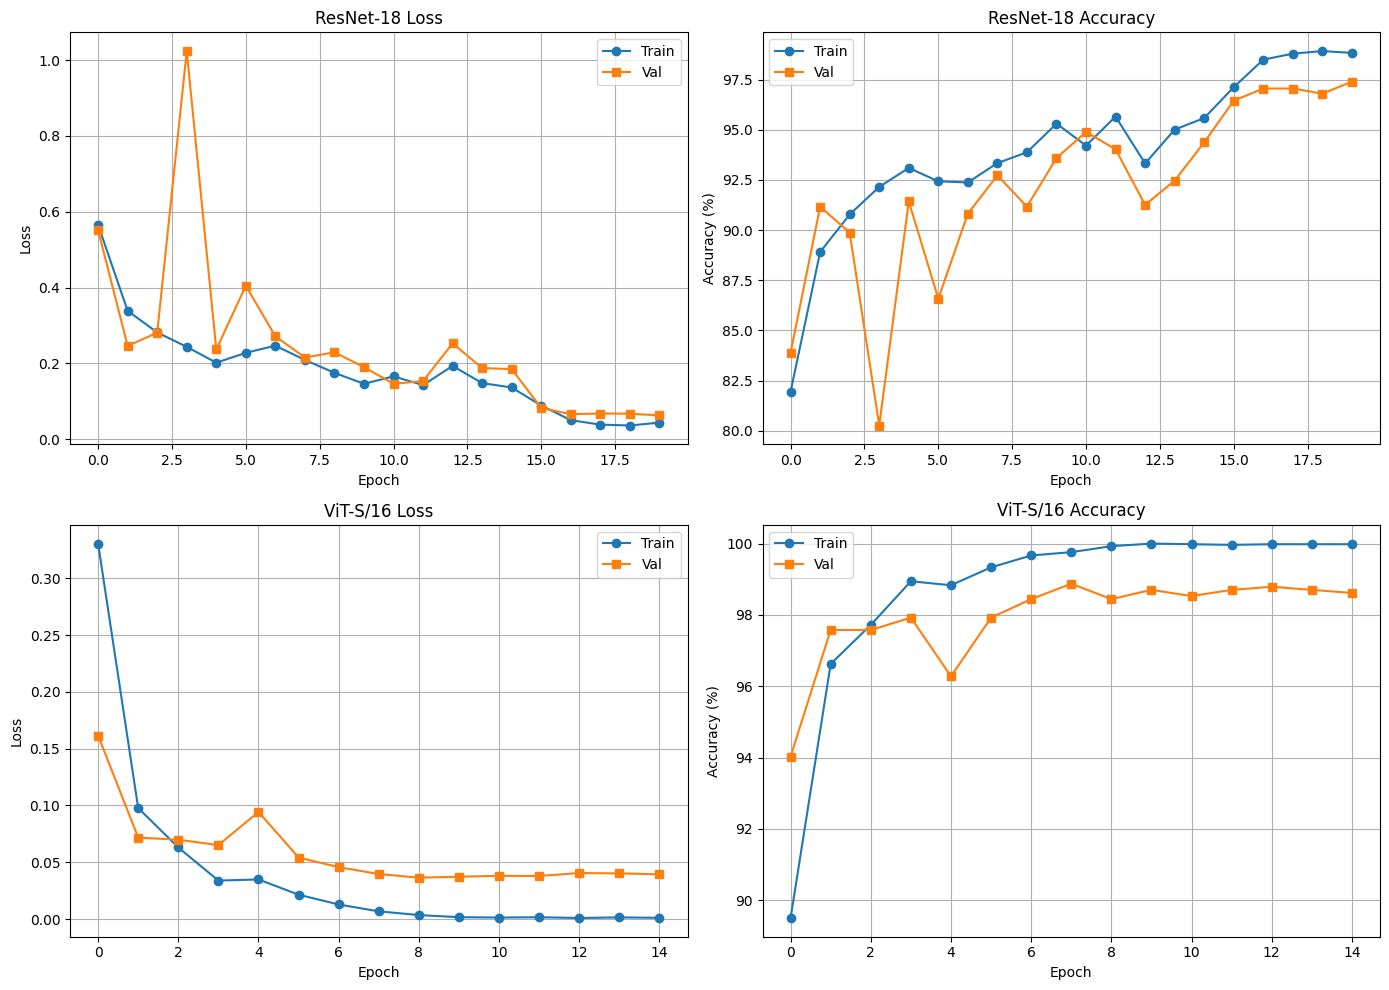

In [25]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Define OUTPUT_ROOT if it's not already defined in the current session
# This assumes OUTPUT_ROOT was set as /content/drive/MyDrive/MA_Thesis/RESISC45_SUBSET_Training
# If your OUTPUT_ROOT path is different, please adjust it here.
# Checking if OUTPUT_ROOT is already defined to avoid re-defining if notebook state was preserved
if 'OUTPUT_ROOT' not in locals():
    OUTPUT_ROOT = Path("/content/drive/MyDrive/MA_Thesis/RESISC45_SUBSET_Training")

# Load training histories from JSON files
with open(OUTPUT_ROOT / 'resnet18_history.json', 'r') as f:
    resnet_history = json.load(f)

with open(OUTPUT_ROOT / 'vit_history.json', 'r') as f:
    vit_history = json.load(f)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ResNet Loss
axes[0, 0].plot(resnet_history['train_loss'], label='Train', marker='o')
axes[0, 0].plot(resnet_history['val_loss'], label='Val', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('ResNet-18 Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# ResNet Accuracy
axes[0, 1].plot(resnet_history['train_acc'], label='Train', marker='o')
axes[0, 1].plot(resnet_history['val_acc'], label='Val', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('ResNet-18 Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# ViT Loss
axes[1, 0].plot(vit_history['train_loss'], label='Train', marker='o')
axes[1, 0].plot(vit_history['val_loss'], label='Val', marker='s')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('ViT-S/16 Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# ViT Accuracy
axes[1, 1].plot(vit_history['train_acc'], label='Train', marker='o')
axes[1, 1].plot(vit_history['val_acc'], label='Val', marker='s')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('ViT-S/16 Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(OUTPUT_ROOT / 'training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary & Next Steps

In [29]:
import json
from pathlib import Path

# Define OUTPUT_ROOT if it's not already defined
if 'OUTPUT_ROOT' not in locals():
    OUTPUT_ROOT = Path("/content/drive/MyDrive/MA_Thesis/RESISC45_SUBSET_Training")

# Load training histories to extract best metrics
with open(OUTPUT_ROOT / 'resnet18_history.json', 'r') as f:
    resnet_history_loaded = json.load(f)

with open(OUTPUT_ROOT / 'vit_history.json', 'r') as f:
    vit_history_loaded = json.load(f)

# Determine best ResNet-18 metrics from loaded history
resnet_best_val_acc = max(resnet_history_loaded['val_acc'])
resnet_best_epoch = resnet_history_loaded['val_acc'].index(resnet_best_val_acc) + 1

# Determine best ViT-S/16 metrics from loaded history
vit_best_val_acc = max(vit_history_loaded['val_acc'])
vit_best_epoch = vit_history_loaded['val_acc'].index(vit_best_val_acc) + 1

summary = {
    'dataset': 'RESISC45 (11 classes)',
    'total_images': len(all_paths),
    'split': {
        'train': len(split_data['train']['paths']),
        'val': len(split_data['val']['paths']),
        'test': len(split_data['test']['paths'])
    },
    'resnet18': {
        'best_val_acc': resnet_best_val_acc,
        'best_epoch': resnet_best_epoch,
        'test_acc': resnet_test_acc,
        'total_epochs': len(resnet_history_loaded['train_loss'])
    },
    'vit_small': {
        'best_val_acc': vit_best_val_acc,
        'best_epoch': vit_best_epoch,
        'test_acc': vit_test_acc,
        'total_epochs': VIT_CONFIG['epochs']
    }
}

# Save summary
with open(OUTPUT_ROOT / 'training_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n" + "="*60)
print("RESISC45 TRAINING COMPLETE")
print("="*60)
print(f"\nDataset: {summary['dataset']}")
print(f"Total images: {summary['total_images']}")
print(f"Split: {summary['split']['train']} / {summary['split']['val']} / {summary['split']['test']}")
print(f"\nResNet-18:")
print(f"  Best Val Acc: {summary['resnet18']['best_val_acc']:.2f}% (Epoch {summary['resnet18']['best_epoch']})")
print(f"  Test Acc: {summary['resnet18']['test_acc']:.2f}%")
print(f"\nViT-S/16:")
print(f"  Best Val Acc: {summary['vit_small']['best_val_acc']:.2f}% (Epoch {summary['vit_small']['best_epoch']})")
print(f"  Test Acc: {summary['vit_small']['test_acc']:.2f}%")
print(f"\nAll files saved to: {OUTPUT_ROOT}")
print("="*60)




RESISC45 TRAINING COMPLETE

Dataset: RESISC45 (11 classes)
Total images: 7700
Split: 5390 / 1155 / 1155

ResNet-18:
  Best Val Acc: 97.40% (Epoch 20)
  Test Acc: 96.54%

ViT-S/16:
  Best Val Acc: 98.87% (Epoch 8)
  Test Acc: 98.10%

All files saved to: /content/drive/MyDrive/MA_Thesis/RESISC45_SUBSET_Training
